# Dask 

Dask is a parallelization library for Python that works on your laptop all the way to cluster-scale (ie. distributed multi-node)

Main focus on creating distributed array-like abstraction: Numpy- and Pandas-like behavior.

Stack:

- Array, bag, dataframe, delayed
- Graph spec
- Scheduler

Let's you focus on algorithms and not scheduling.

In [1]:
!brew install graphviz ## on a mac
#!apt-get install graphviz ## on linux
!pip install graphviz ## dont do this with conda, installs a Python 2 package...

Fetching package metadata .......
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /Users/jbloom/anaconda/envs/seminar:
#
dask                      0.11.0                   py35_0  
distributed               1.13.2                   py35_0  


## Dask Dataframes

meant to mimick most of pandas dataframes, but now these dataframes can be out of core.

In [26]:
!ls -lah ../02_Plotting_and_Viz/data/uber-raw-data-apr14.csv

-rw-r--r--+ 1 jbloom  staff    25M Sep  7 22:21 ../02_Plotting_and_Viz/data/uber-raw-data-apr14.csv


In [29]:
%load_ext snakeviz

In [30]:
%%snakeviz
import pandas as pd
df = pd.read_csv("../02_Plotting_and_Viz/data/uber-raw-data-apr14.csv")

 
*** Profile stats marshalled to file '/var/folders/dc/1sk9z_cx15s7g6895fqjlp7h0000gn/T/tmpjuwp7yfl'. 


In [31]:
%%snakeviz
import dask.dataframe as dd
df = dd.read_csv("../02_Plotting_and_Viz/data/uber-raw-data-apr14.csv")

 
*** Profile stats marshalled to file '/var/folders/dc/1sk9z_cx15s7g6895fqjlp7h0000gn/T/tmp4411f316'. 


Some of the reading in is delayed, but we can still inspect the data.

In [32]:
df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Other operations are delayed until you compute them:

In [33]:
df.describe()

dd.DataFrame<describ..., npartitions=1>

In [34]:
df.describe().compute()

,Lat,Lon
count,564516.000000,564516.000000
mean,40.740005,-73.976817
std,0.036083,0.050426
min,40.072900,-74.773300
25%,40.722500,-73.997700
50%,40.742500,-73.984800
75%,40.760700,-73.970000
max,42.116600,-72.066600


In [40]:
df.describe()['Lat'].compute()

count    564516.000000
mean         40.740005
std           0.036083
min          40.072900
25%          40.722500
50%          40.742500
75%          40.760700
max          42.116600
Name: Lat, dtype: float64

`dask.delayed` (a la joblib):
 
   - `delayed(function)(*args, **kwargs)` -> lazy function that hasn't yet been evaluated
   - `delated(data)` -> lazy object that pretends to be your data
 
 See the excellent talk at SciPy 2016: https://www.youtube.com/watch?v=PAGjm4BMKlk&list=PLYx7XA2nY5Gf37zYZMw6OqGFRPjB1jCy6

In [1]:
# get a local Exector
from distributed import Executor
Executor(set_as_default=True)

<Client: scheduler="127.0.0.1:8786" processes=4 cores=4>

In [2]:
import random
from dask import delayed, visualize
from time import sleep

@delayed(pure=True)
def add(a,b):
    sleep(random.random())
    return a+b

@delayed(pure=True)
def mul(a,b):
    sleep(random.random())
    return a*b

@delayed(pure=True)
def inc(a):
    sleep(random.random())
    return a + 1

In [3]:
x = add(1,2)
x

Delayed('add-86edde1ec820d5e1e6bcb1a04268d4c4')

In [4]:
x.compute()

3

In [5]:
a = inc(1)
b = mul(1,2)
c = add(a,b)
c

Delayed('add-ee6d8a536c4121f12d3b944e495e6f4b')

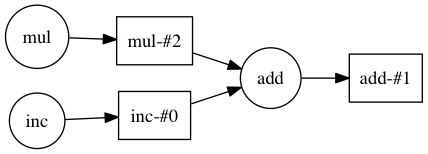

In [6]:
c.visualize(rankdir="LR")

In [7]:
c.compute()

4

### Loops

In [11]:
results = []
for x in range(4):
    a = inc(1)
    b = mul(1,x)
    c = add(a,b)
    results.append(c)

total = delayed(sum,pure=True)(results)
total

Delayed('sum-1ce076200db274ed49a4343e802514bf')

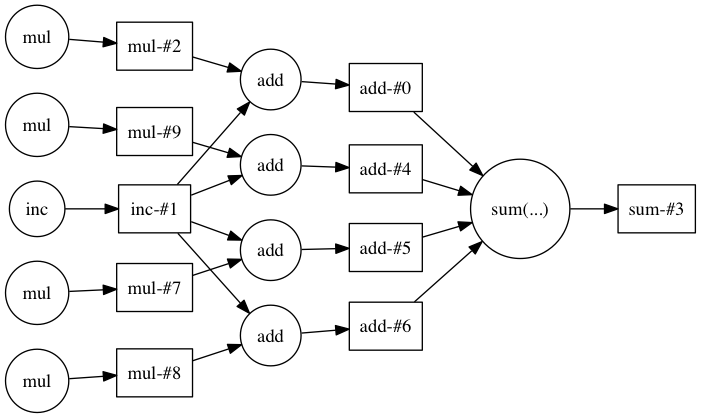

In [12]:
total.visualize(rankdir="LR")

`pure=True`: finds nested shared expressions deep in code that dont need to be recomputed. Eg. `inc(1)` here is the same so it only gets called once. A pure function should have no side-effects.

In [13]:
total.compute()

14

In [14]:
results = []
for y in range(2,10,2):
    for x in range(4):
        a = inc(1)
        b = mul(y,x)
        c = add(a,b)
        results.append(c)

total = delayed(sum,pure=True)(results)
total

Delayed('sum-effd451ec46326f9e73d4616234ba976')

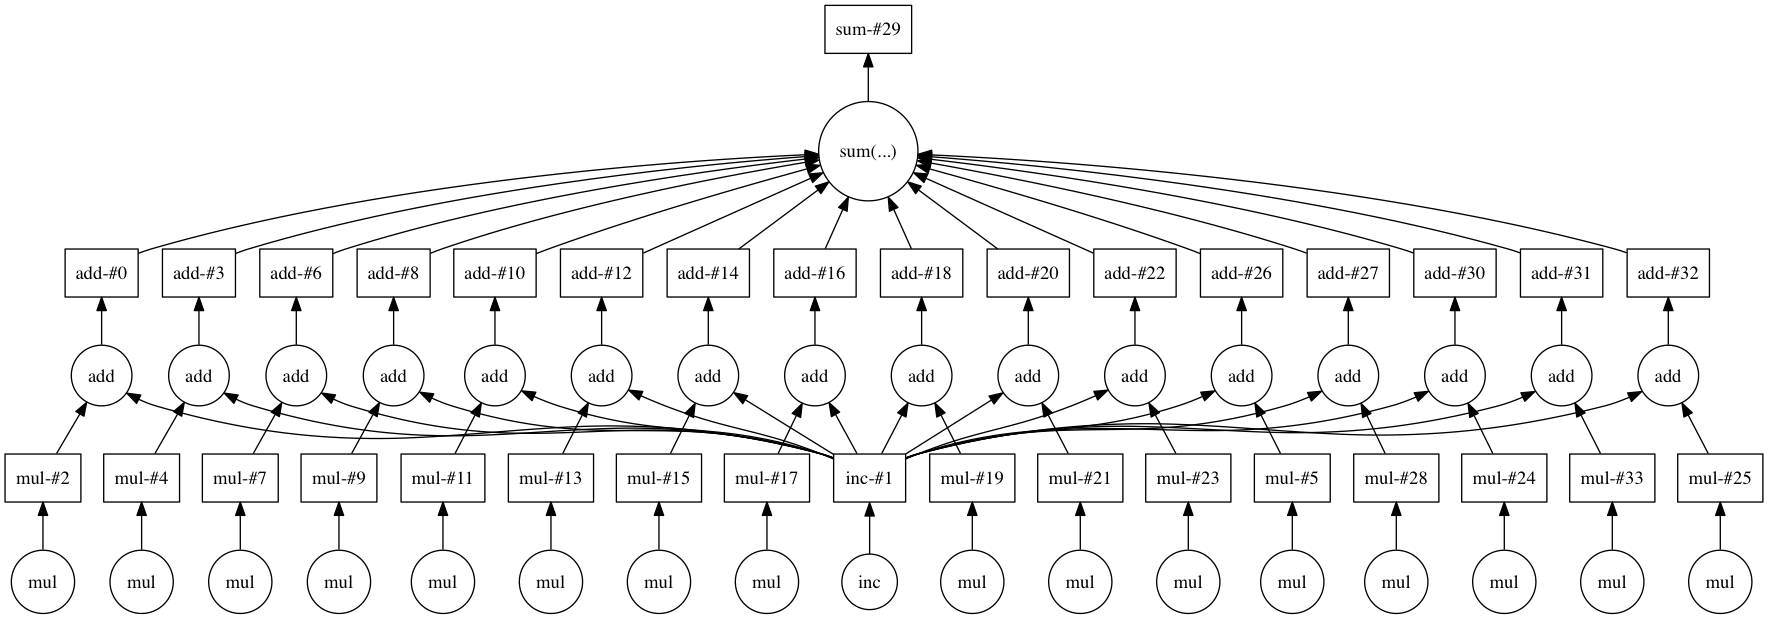

In [15]:
total.visualize()

In [16]:
total.compute()

152

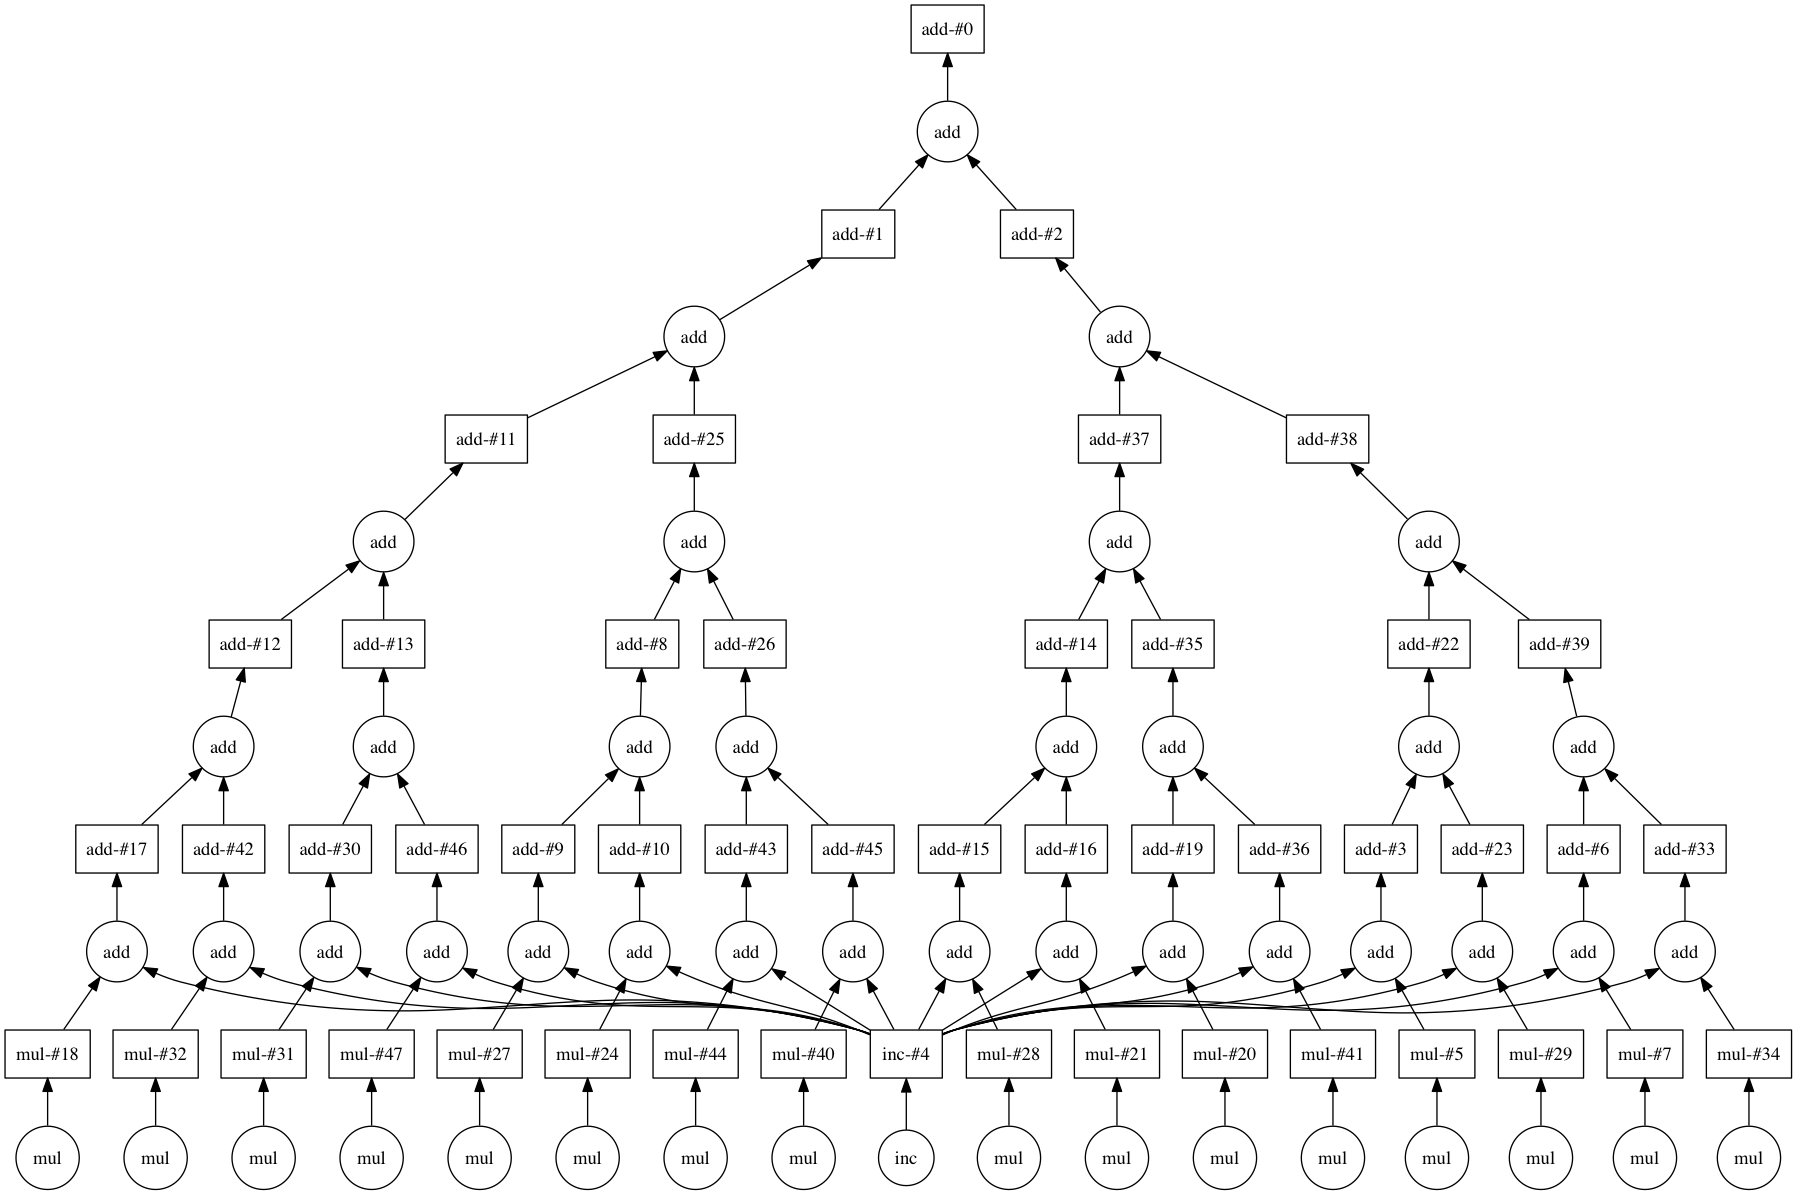

In [19]:
# Tree reduction --- add up pairwise
while len(results) > 1:
    new_results = []
    
    for i in range(0,len(results),2):
        res = add(results[i], results[i+1])
        new_results.append(res)
    
    results = new_results

total = results[0]
total.visualize()

In [20]:
total.compute()

152

Note: you cannot iterate over a delayed object and you can't use them in case statements (because we dont know how long they are until they've been computed)

In [18]:
for x in range(inc(1)):
    print("hey!")

TypeError: 'Delayed' object cannot be interpreted as an integer

## scheduling the execution

where you run a certain piece of a parallel task depends on your architecture, what needs each piece has, and what the bottlenecks are in moving data between pieces.

The **single machine scheduler** is optimizes for larger-than-memory use. It uses:
  
   - Parallel CPU
   - Minimizes RAM: tries to remove intermediary tasks that aren't needed anymore
   - low overhead: 100$\mu$s per task
 

**Distributed scheduler** - tries to minimize data movement so you dont have to move data between computers unnecessarily.
 
 - distributed to schedule across many workers
 - works well with distributed datastores (HDFS)
 - asynchronous
 - data local
 
run `dask-scheduler` on the command line and then 